In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'details', 'categories', 'url'])

In [2]:
X, y = mnist['data'], mnist['target']
X.shape

(70000, 784)

In [3]:
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [3]:
y.shape

(70000,)

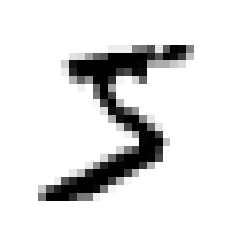

In [4]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)
plt.imshow(some_digit_image,cmap='binary')
plt.axis('off')
plt.show()

In [5]:
y[0]

'5'

In [6]:
import pandas as pd
import numpy as np
y = y.astype(np.uint8)

In [7]:
X_train,X_test,y_train,y_test = X[:6000],X[6000:],y[:6000],y[6000:]

In [8]:
y_train.shape

(6000,)

### Training a Binary Classifier

In [9]:
y_train_5 = (y_train==5)
y_test_5 = (y_test==5)

In [10]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train,y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [11]:
sgd_clf.predict([some_digit]) #Predicted that this image represent 5 is true

array([ True])

### Stratified Cross Validation

In [12]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3,random_state=42)

for train_index, test_index in skfolds.split(X_train,y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    X_test_folds = X_train[test_index]
    y_train_folds = y_train_5[train_index]
    y_test_folds = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds,y_train_folds)
    y_pred = clone_clf.predict(X_test_folds)
    n_correct = sum(y_pred == y_test_folds)
    print(n_correct/len(y_pred)) #Calculating Accuracy score here

0.960519740129935
0.965
0.9654827413706853


### Normal CrossValidation Score

In [13]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf,X_train,y_train_5,scoring='accuracy',cv=3)

array([0.96051974, 0.965     , 0.96548274])

### Base Estimator ----- Dumb Estimator

In [14]:
from sklearn.base import BaseEstimator
class Never5classifier(BaseEstimator):
    def fit(self,X,y=None):
        pass
    def predict(self,X):
        return np.zeros((len(X),1),dtype=bool)

In [15]:
never_5_clf = Never5classifier()
cross_val_score(never_5_clf,X_train,y_train_5,cv=3,scoring='accuracy')

array([0.91 , 0.915, 0.918])

## Confusion Matrix

In [16]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf,X_train,y_train_5,cv=3)

In [17]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_pred,y_train_5)

array([[5391,  123],
       [  95,  391]], dtype=int64)

In [18]:
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_perfect_predictions,y_train_5) #Perfect predictions

array([[5486,    0],
       [   0,  514]], dtype=int64)

##### Precision, Recall and F1-Score

In [19]:
from sklearn.metrics import precision_score,recall_score
print('Precision:',precision_score(y_train_pred,y_train_5))
print('Recall:',recall_score(y_train_pred,y_train_5))

Precision: 0.7607003891050583
Recall: 0.8045267489711934


In [20]:
from sklearn.metrics import f1_score
f1_score(y_train_pred,y_train_5)

0.782

#### Precision and Recall Tradeoff

In [21]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([38042.34312442])

In [22]:
thresold=0
y_some_digit_pred = (y_scores > thresold)
y_some_digit_pred

array([ True])

In [23]:
thresold=80000
y_some_digit_pred = (y_scores > thresold)
y_some_digit_pred

array([False])

In [24]:
y_scores = cross_val_predict(sgd_clf,X_train,y_train_5,cv=3,method='decision_function')

### Precison and Recall Curves - To choose Precison and Recall value

In [25]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5,y_scores)

In [26]:
def plot_precision_vs_recall_curve(precisions,recalls,thresholds):
    plt.plot(thresholds,precisions[:-1],"b--",label="Precision")
    plt.plot(thresholds,recalls[:-1],"g-",label="Recall")

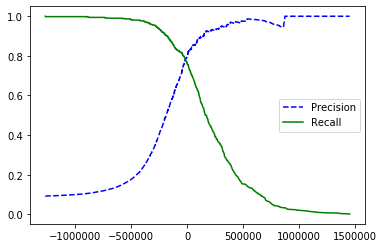

In [27]:
plot_precision_vs_recall_curve(precisions,recalls,thresholds)
plt.legend()
plt.show()

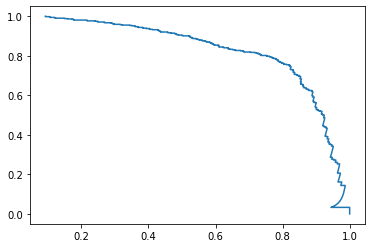

In [28]:
plt.plot(precisions,recalls)
plt.show()

##### Now Selecting Threshold at 90% precision

In [29]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

y_train_pred_90_precision = (y_scores >= threshold_90_precision)

In [30]:
precision_score(y_train_5,y_train_pred_90_precision)

0.9003115264797508

In [31]:
recall_score(y_train_5,y_train_pred_90_precision)

0.5622568093385214

#### The ROC Curve

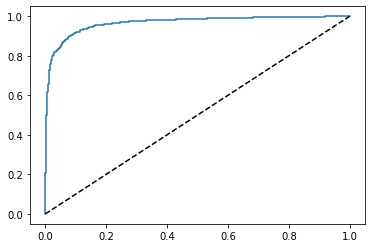

In [32]:
from sklearn.metrics import roc_curve
fpr, tpr,thresholds = roc_curve(y_train_5,y_scores)
def plot_roc_curve(fpr,tpr):
    plt.plot(fpr,tpr)
    plt.plot([0,1],[0,1],'k--') #Dumb Model
plot_roc_curve(fpr,tpr)
plt.show()

In [33]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5,y_scores)

0.9661043817229851

### Randomforest Classifier

In [34]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf,X_train,y_train_5,cv=3,method='predict_proba')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [35]:
y_scores_forest = y_probas_forest[:,1]
fpr_forest,tpr_forest,thresolds_forest = roc_curve(y_train_5,y_scores_forest)

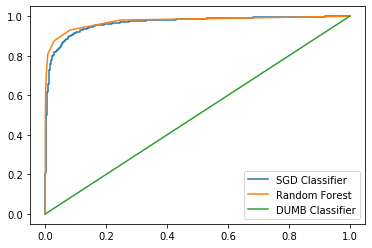

In [38]:
plt.plot(fpr,tpr,label='SGD Classifier')
plt.plot(fpr_forest,tpr_forest,label='Random Forest')
plt.plot([0,1],[0,1],label='DUMB Classifier')
plt.legend()
plt.show()

In [40]:
roc_auc_score(y_train_5,y_scores_forest)

0.9744985821709595

# Multiclass Classification

In [42]:
from sklearn.svm import SVC
svm_clf = SVC() #OvO
svm_clf.fit(X_train,y_train)
svm_clf.predict([some_digit])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


array([5], dtype=uint8)

In [43]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.8249344 ,  8.01830986,  0.81268669,  4.8465137 ,  5.87200033,
         9.29462954,  3.8465137 ,  6.94086295, -0.21310287,  2.83645231]])

In [44]:
np.argmax(some_digit_scores)

5

In [45]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [46]:
svm_clf.classes_[np.argmax(some_digit_scores)]

5

### Building OvR-esque model for SVC

In [47]:
from sklearn.multiclass import OneVsRestClassifier
ovr = OneVsRestClassifier(SVC())
ovr.fit(X_train,y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarni

OneVsRestClassifier(estimator=SVC(C=1.0, cache_size=200, class_weight=None,
                                  coef0=0.0, decision_function_shape='ovr',
                                  degree=3, gamma='auto_deprecated',
                                  kernel='rbf', max_iter=-1, probability=False,
                                  random_state=None, shrinking=True, tol=0.001,
                                  verbose=False),
                    n_jobs=None)

In [48]:
ovr.predict([some_digit])

array([5], dtype=uint8)

In [49]:
len(ovr.estimators_)

10

#### Training on SGD Classfier

In [50]:
sgd_clf.fit(X_train,y_train)
sgd_clf.predict([some_digit])

array([5], dtype=uint8)

In [51]:
sgd_clf.decision_function([some_digit])

array([[-735711.69660953, -857058.38635209, -281086.00104909,
           8289.73273042, -616793.26669143,   29040.2961313 ,
        -492305.02284074, -834395.17091855, -318385.3774766 ,
        -363474.38706356]])

In [52]:
cross_val_score(sgd_clf,X_train,y_train,cv=3,scoring='accuracy')

array([0.8493014 , 0.87506247, 0.8556391 ])

In [53]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_trained_scale = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf,X_trained_scale,y_train,cv=3,scoring='accuracy')

array([0.86726547, 0.89455272, 0.89022556])

##### Error Analysis for Multiclass classification

In [56]:
y_train_pred = cross_val_predict(sgd_clf,X_trained_scale,y_train,cv=3)
conf_matrix = confusion_matrix(y_train,y_train_pred)
conf_matrix

array([[568,   0,   3,   2,   1,  11,   4,   1,   2,   0],
       [  0, 636,   7,   2,   1,   6,   0,   1,  16,   2],
       [ 10,  10, 495,  11,  10,   4,  11,   8,  19,   3],
       [  3,   6,  23, 511,   1,  35,   1,   8,  10,  10],
       [  3,   2,   9,   0, 551,   2,  10,   8,   8,  30],
       [  5,   6,   5,  24,  14, 410,  10,   1,  26,  13],
       [  4,   4,   7,   0,   5,   6, 578,   1,   3,   0],
       [  4,   4,   7,   2,   9,   0,   1, 573,   2,  49],
       [  1,  18,  19,  15,   4,   9,   7,   4, 459,  15],
       [  6,   3,   5,   7,  17,   4,   0,  28,   8, 523]], dtype=int64)

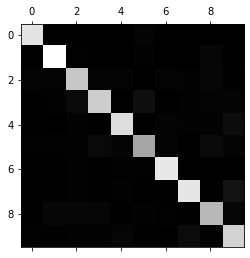

In [57]:
plt.matshow(conf_matrix,cmap=plt.cm.gray)
plt.show()

In [58]:
row_sums = conf_matrix.sum(axis=1,keepdims=True)
norm_conf_matrix = conf_matrix/row_sums

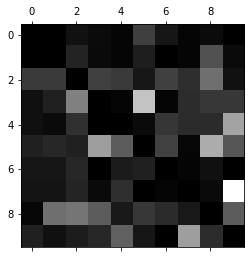

In [60]:
np.fill_diagonal(norm_conf_matrix,0) #Fill only diagonal elements only to keep Errors
plt.matshow(norm_conf_matrix,cmap=plt.cm.gray)
plt.show()

## Multilabel Classification

In [61]:
from sklearn.neighbors import KNeighborsClassifier
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large,y_train_odd]

In [62]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train,y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [63]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [64]:
y_train_pred = cross_val_predict(knn_clf,X_train,y_multilabel,cv=3)

#### Finding the measure for multilabel classification

In [65]:
f1_score(y_multilabel,y_train_pred,average='macro')

0.9500922726736858

## Multioutput Classification

In [66]:
noise = np.random.randint(0,100,(len(X_train),784))
X_train_mod = X_train+noise
noise = np.random.randint(0,100,(len(X_test),784))
X_test_mod = X_test+noise
y_train_mod = X_train
y_test_mod = X_train

In [67]:
knn_clf.fit(X_train_mod,y_train_mod)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

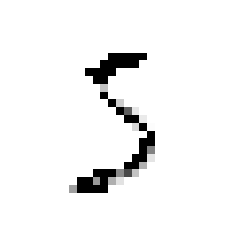

In [68]:
clean_digit = knn_clf.predict([some_digit])
clean_digit_image = clean_digit.reshape(28,28)
plt.imshow(clean_digit_image,cmap='binary')
plt.axis('off')
plt.show()

# MNIST with KNN Classifier - Exercise1

In [ ]:
from sklearn.model_selection import GridSearchCV
params = 